# Cluster Analysis

Data reduction in statistics and machine learning: factor analysis, principle components analysis, cluster analysis
 - in statistics, several observed variables might represent a single latent variable (reduce number of dimensions)
 - in spatial analysis, several lat-long points may represent a single "place" (reduce number of examples)

Cluster analysis algorithms
 - *k-means* partitions the data space into Voronoi tessellations. Translation: you give it a desired number of clusters and it will partition them into equal-sized clusters (minimizes variance and fails at density-based clustering).
 - *DBSCAN* discovers clusters as dense areas in space, surrounded by sparser areas. Points in the sparse areas are usually considered noise (needs there to be drop-offs in density to detect cluster borders).
 - *OPTICS* is similar to DBSCAN, but lets you find clusters of varying density.
 - many more...

DBSCAN is appropriate for geospatial data, and we'll focus on it today using scikit-learn.

- http://scikit-learn.org/stable/modules/clustering.html
- http://scikit-learn.org/stable/modules/clustering.html#dbscan

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

## Part 1: spatial clustering into groups

In [2]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


In [3]:
# how many rows are in this data set?
len(df)

1759

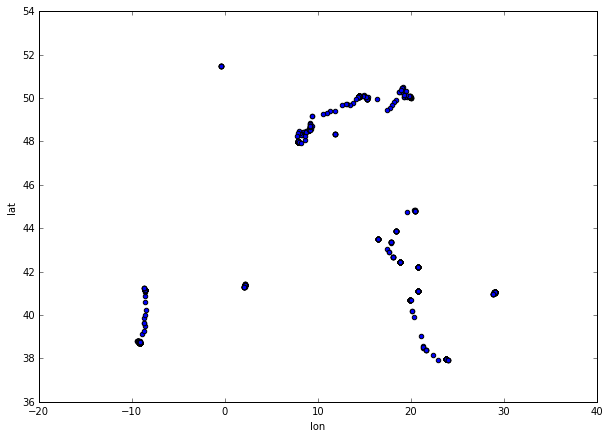

In [4]:
# scatterplot it to get a sense of what it looks like
df.plot(kind='scatter', x='lon', y='lat', figsize=[10,7])

In [5]:
# convert the lat/long columns from dataframe to a numpy matrix
df = df.sort_values(by='lon', ascending=False)
coordinates = df.as_matrix(columns=['lon', 'lat'])
coordinates

array([[ 29.0112146,  41.0142474],
       [ 29.0107621,  41.0149629],
       [ 29.0066639,  41.021378 ],
       ..., 
       [ -9.3923114,  38.7893195],
       [ -9.4084998,  38.8166107],
       [ -9.4251031,  38.8011712]])

Now, compute DBSCAN to cluster these data

In [6]:
# eps is the physical distance from each point that forms its ε-neighborhood
# min_samples is the minimum cluster size, otherwise the point(s) are noise
db = DBSCAN(eps=3, min_samples=10).fit(coordinates)
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# calculate the number of clusters in labels, ignoring noise (which is labeled -1) if present
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(num_clusters)
#str(list(cluster_labels))

5


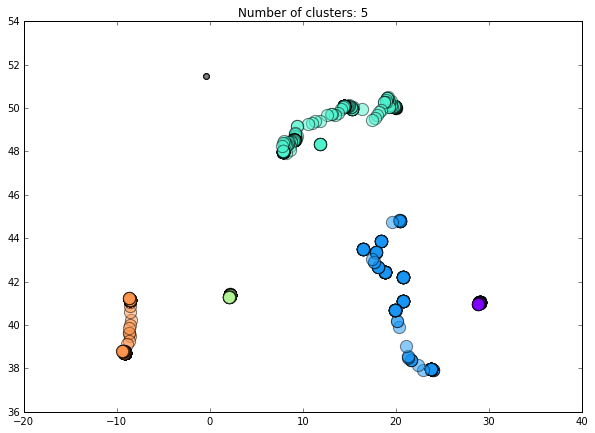

In [7]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=[10,7])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 150
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
    x_coords = coordinates[cluster_labels==cluster_label][:,0]
    y_coords = coordinates[cluster_labels==cluster_label][:,1]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

matplotlib offers lots of built-in colormaps: http://matplotlib.org/examples/color/colormaps_reference.html

The silhouette coefficient evaluates how close a point is to the other points in its cluster in comparison with how close it is to the points in the next nearest cluster. A high silhouette coefficient indicates the points are well-clustered and a low value indicates an outlier.

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [8]:
coefficient = metrics.silhouette_score(coordinates, cluster_labels)
print('Silhouette Coefficient: {:0.3f}'.format(coefficient))

Silhouette Coefficient: 0.768


Now you try: experiment with different epsilon values, minimum sizes, and colormaps.

## Part 2: clustering to reduce data set size

Rather than clustering to discover groups, I want to cluster to reduce the size of my data set. Even zoomed in very close, several locations have hundreds of data points stacked directly on top of each other due to the duration of time spent at one location. Unless we are interested in time dynamics, we simply do not need all of these spatially redundant points – they just bloat the data set’s size.

In [9]:
# set eps low so clusters are only formed by very close points
# set min_samples to 1 so we get no noise - every point will be in a cluster even if it's a cluster of 1
db = DBSCAN(eps=.01, min_samples=1).fit(coordinates)
cluster_labels = db.labels_
#str(list(cluster_labels))

In [10]:
# number of clusters, ignoring noise if present
num_clusters = len(set(cluster_labels)) #- (1 if -1 in labels else 0)
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 158


In [11]:
# create a series to contain the clusters - each element in the series is the points that compose each cluster
clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])
clusters.tail()

153                           [[-9.3619194, 38.8054581]]
154                           [[-9.3717872, 38.8014593]]
155    [[-9.3852125, 38.799727], [-9.3854593, 38.7995...
156                           [[-9.4084998, 38.8166107]]
157                           [[-9.4251031, 38.8011712]]
dtype: object

Calculate the approximate centroid of a cluster of points using shapely's centroid, x, and y attributes. Our distances are small so this Cartesian method is good enough... but might want to project the point data in the future for better accuracy.

In [12]:
# given a cluster of points, return the point nearest to the cluster's centroid
def get_centermost_point(cluster):
    centroid = MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return centermost_point

Geopy's great circle distance calculates the shortest distance between two points along the surface of a sphere. https://en.wikipedia.org/wiki/Great-circle_distance

In [13]:
# find the point in each cluster that is closest to its centroid
centermost_points = clusters.map(get_centermost_point)

# use list comprehension to extract the lat and lon out of the resulting points tuples as new dataframe columns
longitudes = [point[0] for point in centermost_points]
latitudes = [point[1] for point in centermost_points]
representative_points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})
representative_points.tail()

,lat,lon
153,38.805458,-9.361919
154,38.801459,-9.371787
155,38.797314,-9.387921
156,38.816611,-9.408500
157,38.801171,-9.425103


My data set of 1,759 points has been reduced down to a spatially representative sample of 158 points. Last thing - grab the rows in the original dataframe that correspond to these 158 points (so that I keep city, country, and timestamp).

In [14]:
# pull row from full data set (df) where lat/lon match the lat/lon of each row of representative points
# use iloc[0] to pull just the first row if there are multiple matches
rs = representative_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('data/reduced-set.csv', index=False)
rs.tail()

,lat,lon,date,city,country
153,38.805458,-9.361919,05/16/2014 15:58,Lisbon,Portugal
154,38.801459,-9.371787,05/16/2014 15:43,Sintra,Portugal
155,38.797314,-9.387921,05/16/2014 16:58,Sintra,Portugal
156,38.816611,-9.408500,05/16/2014 16:13,Sintra,Portugal
157,38.801171,-9.425103,05/16/2014 13:43,Sintra,Portugal


In [15]:
# to demonstrate the data reduction, compare how many observations of 'Spain' in each data set
print(len(df[df['country']=='Spain']))
print(len(rs[rs['country']=='Spain']))

646
7


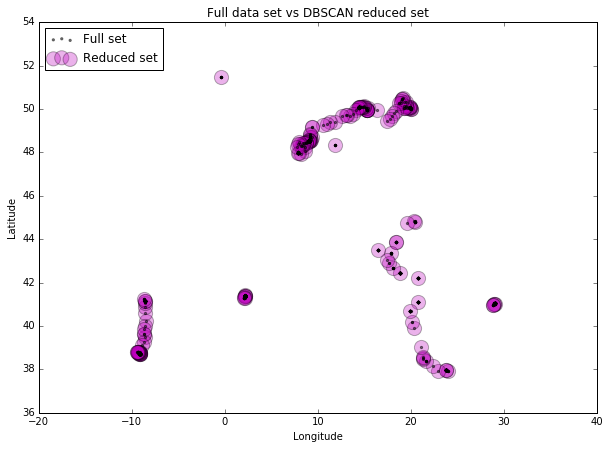

In [16]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10,7])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='m', alpha=0.3, s=200)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.5, s=5)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
plt.show()

Despite the massive reduction in data set size, our smaller set is still spatially representative of the larger set (until you get to very fine spatial scales, as determined by the DBSCAN epsilon value).

If you're interested in cluster analysis and want to explore further, advanced topics include:
 - R-trees: https://en.wikipedia.org/wiki/R-tree
 - k-d trees: https://en.wikipedia.org/wiki/K-d_tree
 - OPTICS: https://en.wikipedia.org/wiki/OPTICS_algorithm
 - ELKI, a Java-based tool, lets you use DBSCAN explicitly with lat-long distances: http://elki.dbs.ifi.lmu.de/